# Importing Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/virat-kohli-odi-dataset/Virat_Kohli_ODI.csv
/kaggle/input/virat-kohli-odi-dataset/DataDictionary-Cricket.csv


# Loading Data

In [2]:
odi_df = pd.read_csv("/kaggle/input/virat-kohli-odi-dataset/Virat_Kohli_ODI.csv")
odi_df.head()

,Runs,Mins,BF,4s,6s,SR,Pos,Dismissal,Inns,Opposition,Ground,Start Date
0,12,33,22,1,0,54.54,2,lbw,1,v Sri Lanka,Dambulla,18-Aug-08
1,37,82,67,6,0,55.22,2,caught,2,v Sri Lanka,Dambulla,20-Aug-08
2,25,40,38,4,0,65.78,1,run out,1,v Sri Lanka,Colombo (RPS),24-Aug-08
3,54,87,66,7,0,81.81,1,bowled,1,v Sri Lanka,Colombo (RPS),27-Aug-08
4,31,45,46,3,1,67.39,1,lbw,2,v Sri Lanka,Colombo (RPS),29-Aug-08


In [3]:
odi_data_dict = pd.read_csv("/kaggle/input/virat-kohli-odi-dataset/DataDictionary-Cricket.csv")
odi_data_dict

,Column Name,Description
0,Runs,"The number of runs scored by Virat in that particular match. If he remained not out, then it has been marked by an asterisk (*)"
1,Mins,Total time taken by Virat to score the runs. Essentially the time for which Virat batted in that match.
2,BF,Total number of balls faced by Virat to score the runs in that match.
3,4s,Number of fours hit by Virat in that match
4,6s,Number of sixes hit by Virat in that match
5,SR,The strike rate of Virat in that match.
6,Pos,The batting position of Virat in that match.
7,Dismissal,The mode of dismissal in that match.
8,Inns,Denotes whether team batted first or batted second
9,Opposition,The opposition country against which Virat played.


# Data Pre-Processing

In [4]:
odi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Runs        132 non-null    object
 1   Mins        132 non-null    object
 2   BF          132 non-null    int64 
 3   4s          132 non-null    int64 
 4   6s          132 non-null    int64 
 5   SR          132 non-null    object
 6   Pos         132 non-null    int64 
 7   Dismissal   132 non-null    object
 8   Inns        132 non-null    int64 
 9   Opposition  132 non-null    object
 10  Ground      132 non-null    object
 11  Start Date  132 non-null    object
dtypes: int64(5), object(7)
memory usage: 12.5+ KB


In [5]:
# Checking missing values for 'Mins'
odi_df[odi_df['Mins']=="-"]

,Runs,Mins,BF,4s,6s,SR,Pos,Dismissal,Inns,Opposition,Ground,Start Date
10,107,-,114,11,1,93.85,4,caught,2,v Sri Lanka,Kolkata,24-Dec-09
13,31,-,46,1,0,67.39,5,caught,1,v South Africa,Jaipur,21-Feb-10
14,57,-,71,4,1,80.28,3,caught,2,v South Africa,Ahmedabad,27-Feb-10
51,86*,-,99,11,0,86.86,4,not out,2,v England,Mumbai,23-Oct-11
105,49,-,44,2,2,111.36,4,caught,2,v Sri Lanka,Ahmedabad,6-Nov-14
106,53,-,61,4,1,86.88,4,caught,2,v Sri Lanka,Hyderabad (Deccan),9-Nov-14


In [6]:
# Calculating average minutes per ball to use it for filling missing values in 'Mins' column
temp_df = odi_df[odi_df['Mins']!="-"]
temp_df['Mins'] = temp_df['Mins'].astype(int)
temp_arr = temp_df.agg({'Mins':'sum', 'BF':'sum'}).values
avg_min_per_ball = temp_arr[1]/temp_arr[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Impute missing values in 'Mins' columns by 'BF'*avg_min_per_ball
odi_df['Mins'] = odi_df[['Mins','BF']].apply(lambda x: int(x[1]*avg_min_per_ball) if x[0]=='-' else int(x[0]), axis=1)

In [8]:
# Create a new boolean column 'Not Out'
odi_df['Not Out'] = odi_df['Runs'].apply(lambda x: 'Yes' if '*' in x else 'No')

In [9]:
# Convert datatype of 'Runs' column to integer
odi_df['Runs'] = odi_df['Runs'].apply(lambda x: int(x[:-1]) if '*' in x else int(x))

In [10]:
# Convert datatype of 'Start Date' to datetime
odi_df['Start Date'] = pd.to_datetime(odi_df['Start Date'])
# Create a new column 'Quarter' from 'Start Date'
odi_df['Quarter'] = odi_df['Start Date'].dt.quarter
# Create a new column 'Year' from 'Start Date'
odi_df['Year'] = odi_df['Start Date'].dt.year

In [11]:
# Checking for missing values in Strike Rate
odi_df[odi_df['SR']=="-"]

,Runs,Mins,BF,4s,6s,SR,Pos,Dismissal,Inns,Opposition,Ground,Start Date,Not Out,Quarter,Year
15,0,3,0,0,0,-,3,run out,1,v Zimbabwe,Bulawayo,2010-05-28,No,2,2010


In [12]:
# Imputing Strike Rate with 0 since for that match Virat got out at 0 and converting it to float type
odi_df[odi_df['SR']=="-"] = 0
odi_df['SR'] = odi_df['SR'].astype(float) 

In [13]:
# Removing row with all Null values
odi_df[odi_df['Year']==0]

,Runs,Mins,BF,4s,6s,SR,Pos,Dismissal,Inns,Opposition,Ground,Start Date,Not Out,Quarter,Year
15,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0


In [14]:
odi_df = odi_df[odi_df['Year']!=0]

# Assignment Questions

## 1. Using the data set, find out the country against which Virat Kohli has the maximum batting average. Here, the batting average is given by (total number of runs Virat scored)/(the total number of matches he played) and not the average runs Virat Kohli scored before getting out.

In [15]:
odi_df.groupby('Opposition').agg({'Runs' : 'sum', 'Opposition':'count'}).head()

,Runs,Opposition
Opposition,,
v Australia,999,20
v Bangladesh,544,8
v England,830,21
v Ireland,34,1
v Netherlands,12,1


In [16]:
dict1 = {}
for i in odi_df.index:   
    runs = odi_df.loc[i].Runs
    country = odi_df.loc[i].Opposition
    if country not in dict1:
        dict1[country] = [runs, 1]
    else:
        dict1[country] = [dict1[country][0]+runs, dict1[country][1]+1]    
dict1

{'v Sri Lanka': [1084, 24],
 'v Australia': [999, 20],
 'v Bangladesh': [544, 8],
 'v South Africa': [558, 15],
 'v Zimbabwe': [215, 4],
 'v New Zealand': [877, 14],
 'v Ireland': [34, 1],
 'v Netherlands': [12, 1],
 'v West Indies': [1009, 19],
 'v Pakistan': [22, 4],
 'v England': [830, 21]}

In [17]:
max = 0
team = ''
for k,v in dict1.items():
    avg = v[0]/v[1]
    if avg> max:
        max = avg
        team = k
max,team

(68.0, 'v Bangladesh')

## 2. Plot a histogram to see where Virat Kohli has scored the most number of times.

**Virat Kohli has the maximum batting average against *Bangladesh***

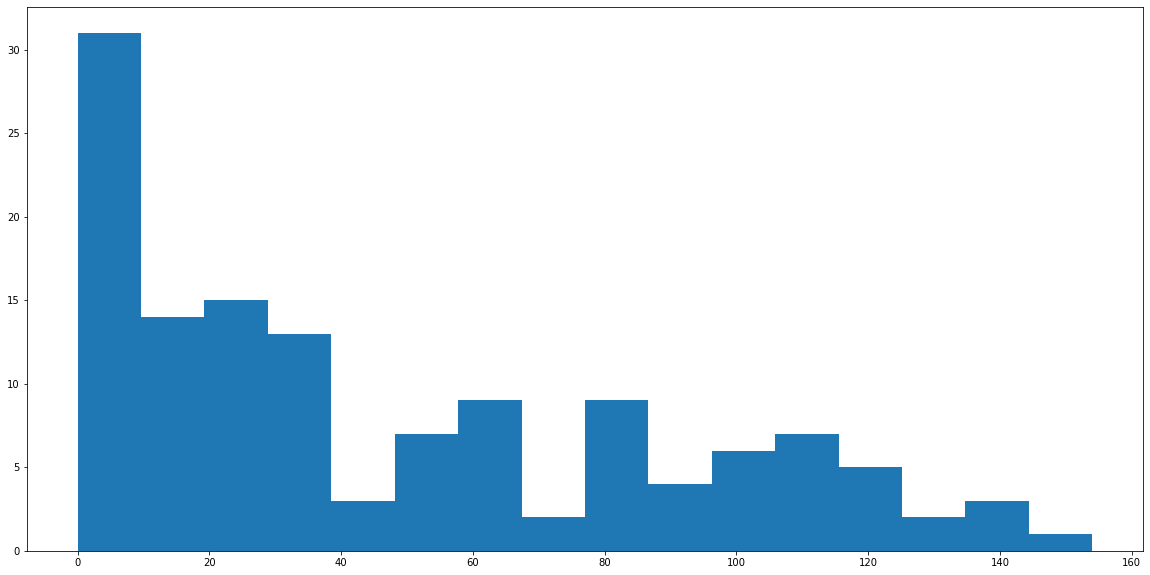

In [18]:
runs= odi_df['Runs']
plt.figure(figsize = (20,10))
plt.hist(runs, bins = 16)
plt.show()

## 3. Whenever Virat Kohli has scored 90-100 runs (exclude 100), what has been the average strike rate?

In [19]:
avg_list = []
for i in odi_df.index:
    row = odi_df.loc[i]
    runs = row['Runs']
    if runs >= 90 and runs <100:
        avg_list.append(float(row['SR']))       
avg_sr = sum(avg_list)/ len(avg_list)
avg_sr

93.1

## 4. Using the previous histogram, find the run interval where Virat has scored the maximum number of sixes. Also, mention the number of fours he hit in the same bracket.

In [20]:
runs= odi_df['Runs']
group_bin = [i//10 for i in runs]
odi_df['Group_Size'] = group_bin
df1 = odi_df.groupby('Group_Size').sum().reset_index()
df1.head()
max_six = 0
for i in df1.index:
    row = (df1.iloc[i])
    six_run = row['6s']
    if max_six<six_run:
        max_six = six_run
        max_four = row['4s']
        group_int = row['Group_Size']
max_six, max_four, group_int

(14.0, 90.0, 10.0)

**In Group *10* i.e; 100,110 runs Kohli hit *14* Sixes and *90* Fours**

## 5. Plot a pie chart to find out the approximate percentage of the times Virat Kohli has been out by LBW in all his innings. Take into account all his innings, including the ones in which he remained not out.

In [21]:
df2= odi_df[['Dismissal','Runs']].groupby('Dismissal').count()
lbw_count = df2.loc['lbw'].values[0]
total = df2.Runs.sum()
lbw_count, total

(9, 131)

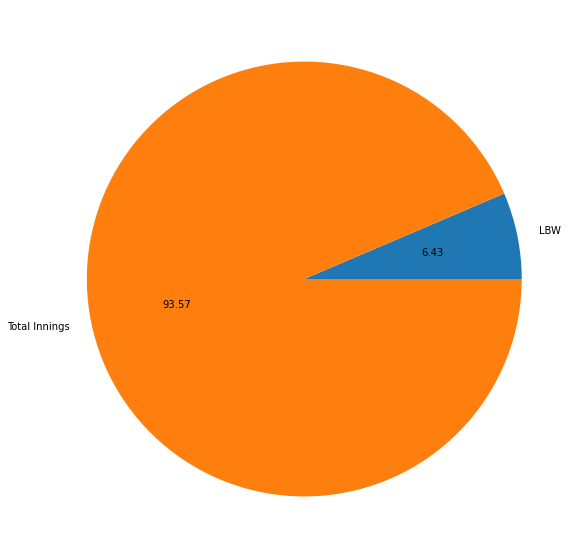

In [22]:
plt.figure(figsize = (10,10))
plt.pie(x = [lbw_count,total],labels= ['LBW','Total Innings'] ,autopct='%.2f')
plt.show()

## 6. Let’s say you want to visualize the consistency of the runs scored by Virat against various teams, i.e. you want to compare the spread of the runs scored by Virat against various teams. Which of the following plots will be the most appropriate for visualizing this?

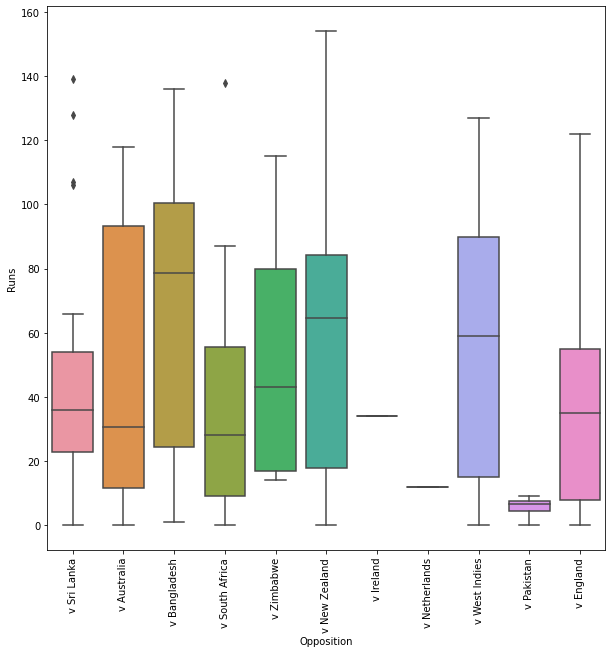

In [23]:
plt.figure(figsize = (10,10))
sns.boxplot(x= 'Opposition', y = 'Runs', data = odi_df)
plt.xticks(rotation = 90)
plt.show()

## 7. In which years have Kohli’s runs kept improving in the Q2-Q4 period given that he played at least one match in that period?

### *Assumption*- Considering Q2, Q3 & Q4 continuous improvement

In [24]:
temp_df = odi_df[odi_df['Quarter'].isin([1,2,3,4])].groupby(['Year','Quarter']).agg({'Runs':'sum', 'Inns':'sum'}).apply(lambda x: x[0]/x[1], axis=1).reindex()

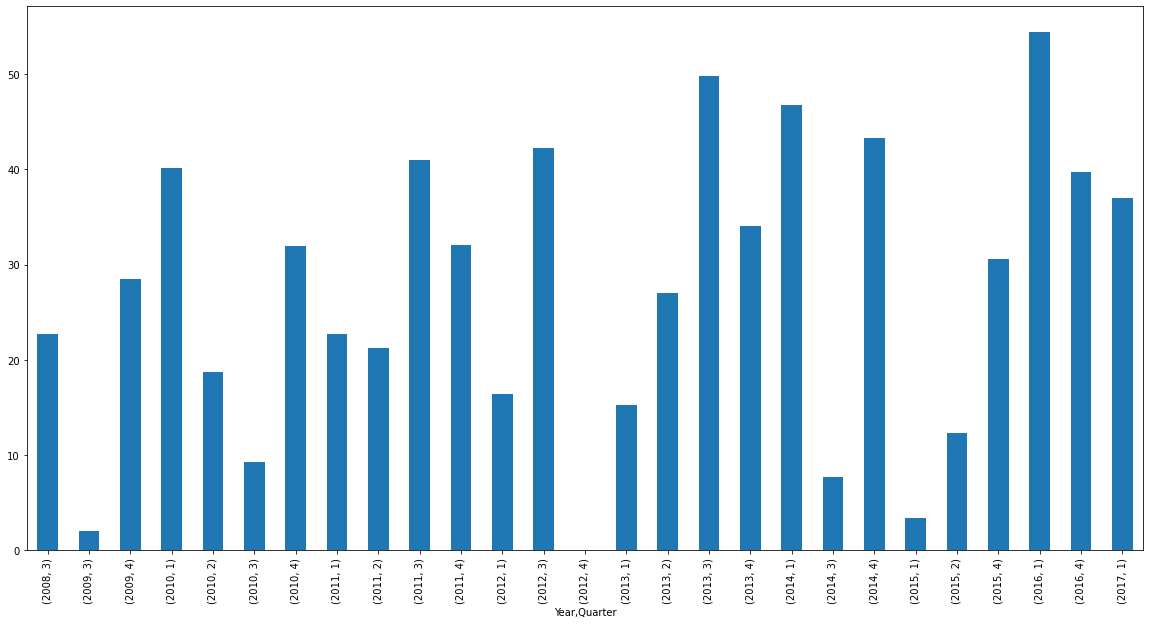

In [25]:
temp_df.plot(kind='bar', figsize = (20,10))
plt.show()

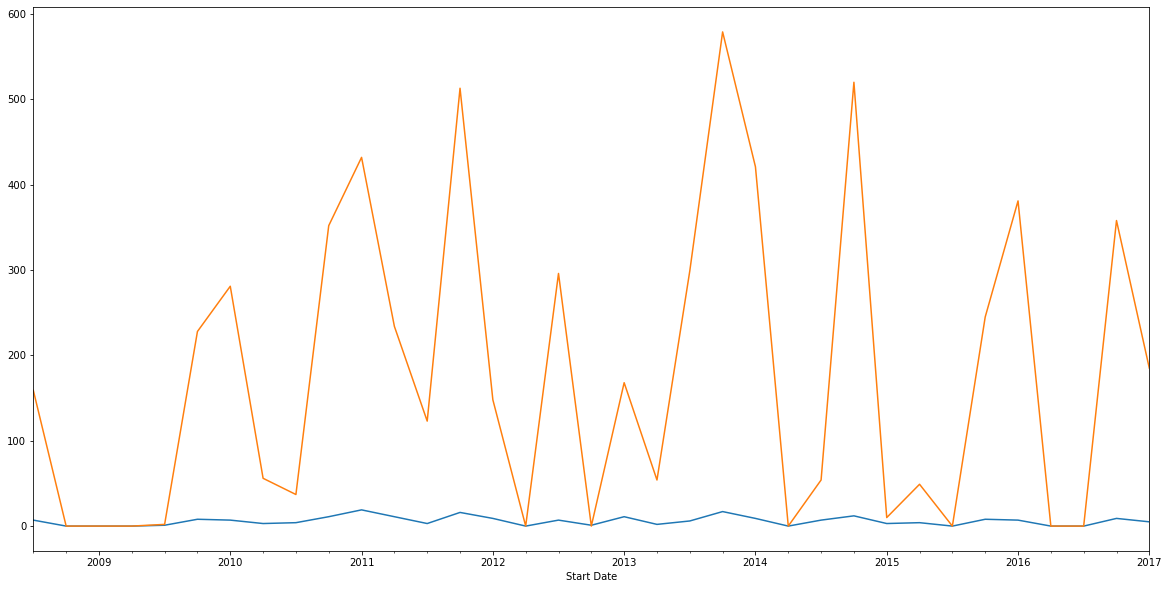

In [26]:
df3 = odi_df[['Start Date','Inns','Runs']]
df3.index = df3['Start Date']
df4  = df3.resample('Q', convention='end').agg('sum')
plt.figure(figsize = (20,10))
df4['Inns'].plot( kind = 'line')
df4['Runs'].plot( kind = 'line')
plt.show()

**For year *2014* and *2015* we can observe there is continuous improvement towards Q4**

## 8. Against which country has Virat scored the maximum aggregate runs in matches where the mode of dismissal was “caught”?

In [27]:
odi_df[odi_df['Dismissal']=='caught'].groupby('Opposition').agg({'Runs':'sum', 'Inns':'sum'}).apply(lambda x: x[0]/x[1], axis=1).idxmax()

'v West Indies'

**Virat scored the maximum aggregate runs in matches against West Indies where the mode of dismissal was “caught”**

## 9. What is the batting position at which Virat has the best average against England?

In [28]:
# Calculating average 
odi_df[odi_df['Opposition']=='v England'].groupby('Pos').agg({'Runs':'sum', 'Inns':'sum'}).apply(lambda x: x[0]/x[1], axis=1)

Pos
3    19.863636
4    39.300000
dtype: float64

In [29]:
# Finding batting position
odi_df[odi_df['Opposition']=='v England'].groupby('Pos').agg({'Runs':'sum', 'Inns':'sum'}).apply(lambda x: x[0]/x[1], axis=1).idxmax()

4

**Virat has best average against England at 4th Batting position**